### Import packages 

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import os

import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random
from PIL import Image

c:\users\samorris\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Check if Keras is using GPU
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [3]:
train_data_dir = 'asl_alphabet_train'
validation_data_dir = 'asl_alphabet_validation'
epochs = 4
batch_size = 64
n_classes = 29
val_percentage = 0.1
img_width, img_height = 150, 150
nb_train_samples = 2000
nb_validation_samples = 200

In [4]:
print(os.path.isdir(train_data_dir))
print(os.listdir(train_data_dir))
classes = os.listdir(train_data_dir)

True
['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [5]:
len(classes)

29

### Let's view some data

In [6]:
def plot_samples(letter,sample_number):
    print("{} Samples images for letter {} ".format(sample_number,letter))
    base_path = 'asl_alphabet_train/'
    img_path = base_path + letter + '/**'
    path_contents = glob(img_path)
    plt.figure(figsize=(24,24))
    for i in range(sample_number):
        imgs = random.sample(path_contents, sample_number)
        plt.subplot(131+i)
        plt.imshow(cv2.imread(imgs[i]))
    return



3 Samples images for letter A 


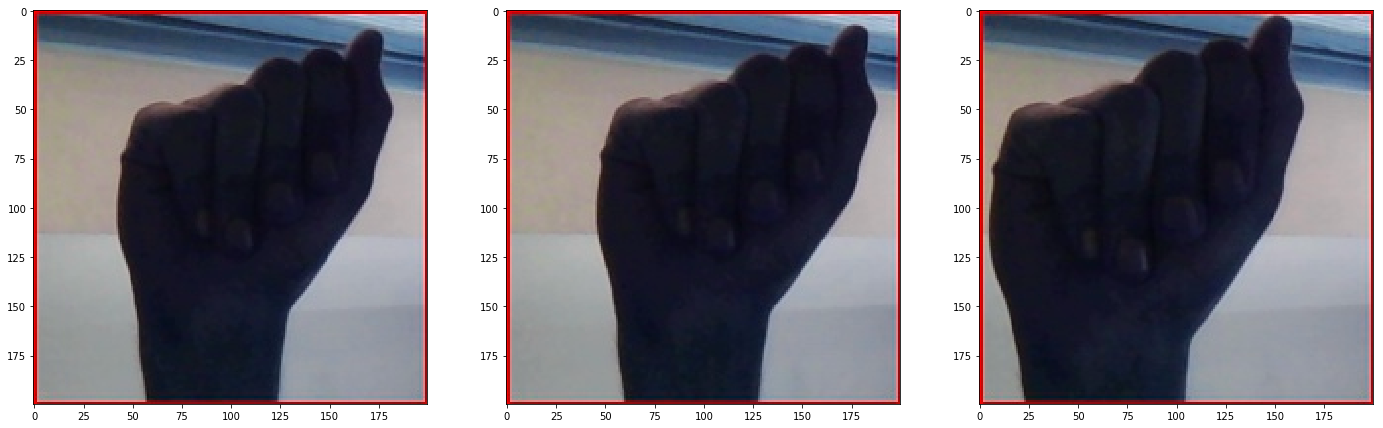

In [7]:
plot_samples('A',3)

2 Samples images for letter F 


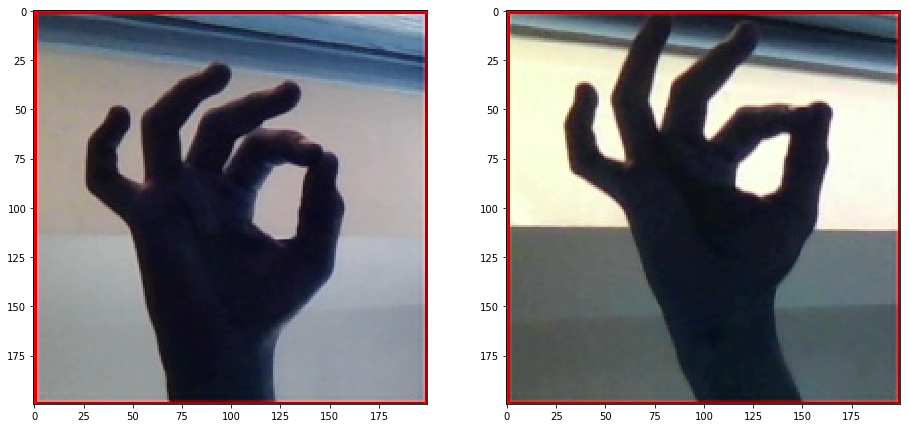

In [8]:
plot_samples('F',2)

### This initial prototype model I will use the Keras image data generator and feed function, however in future interations of this model I will explore different methods of speedy data loads

In [9]:
train_data = ImageDataGenerator(
    rescale=1. / 255,
    samplewise_center=True,
    samplewise_std_normalization=True)

test_data = ImageDataGenerator(rescale=1. / 255)

In [10]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Defining the model, for this prototype I will use a stacked CNN with 50% dropout.

In [11]:
model = Sequential()
model.add(Conv2D(64,kernel_size=4,strides=1, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(64,kernel_size=4,strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=4,strides=1))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=4,strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=4,strides=1))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=4,strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Since we have multi-classes 29 to be exact I will use a catergorical crossentopy loss function

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
               metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 147, 147, 64)      3136      
_________________________________________________________________
activation_1 (Activation)    (None, 147, 147, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 147, 147, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        65600     
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 128)       131200    
__________

In [14]:
train_generator = train_data.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True)

validation_generator = test_data.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

print(train_generator.class_indices)
class_indicies = train_generator.class_indices

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
{'R': 17, 'Z': 25, 'A': 0, 'D': 3, 'P': 15, 'K': 10, 'M': 12, 'C': 2, 'S': 18, 'X': 23, 'G': 6, 'nothing': 27, 'H': 7, 'del': 26, 'L': 11, 'Q': 16, 'N': 13, 'E': 4, 'Y': 24, 'space': 28, 'J': 9, 'O': 14, 'W': 22, 'T': 19, 'V': 21, 'I': 8, 'B': 1, 'F': 5, 'U': 20}


In [15]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose = 1)

Epoch 1/4
1224/31 [=====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### The prediction is good, but not so great on the validation accuracy, this may be due to the way the data was split and balanced between train and test, therefore I will test this model and then improve it with a better data loading process in another prototype

In [18]:
from IPython.display import Image
import numpy as np
from keras.preprocessing import image

In [94]:
def prediction(image_directory):
    img = image.load_img(image_directory, target_size=(img_width,img_height))
    image_rescale = image.img_to_array(img)
    image_rescale = np.expand_dims(image_rescale,axis=0)
    image_test = np.vstack([image_rescale])
    prediction = model.predict_classes(image_test)
    if prediction in class_indicies.values():
        for key, value in class_indicies.items():
            if value == prediction:
                print("I predict this is a {}".format(key))
            

In [95]:
test_image_w= 'asl_alphabet_test/W_test.jpg'

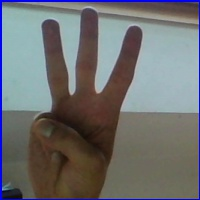

In [96]:
Image(filename=test_image_w)

In [101]:
prediction(test_image_w)

I predict this is a F


In [99]:
test_image_f= 'asl_alphabet_test/F_test.jpg'

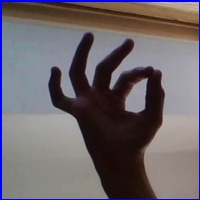

In [100]:
Image(filename=test_image_f)

In [102]:
prediction(test_image_f)

I predict this is a F


In [109]:
test_image_L= 'asl_alphabet_test/L_test.jpg'

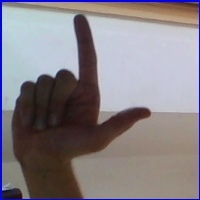

In [110]:
Image(filename=test_image_L)

In [112]:
prediction(test_image_L)

I predict this is a V


### Did well on predicting some of the images, but not all of them, therefore will upload this and this build another prototype